project 1 - discovery

In [108]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
from scipy.stats import linregress
from pprint import pprint
from sodapy import Socrata


In [109]:
# Authenticated client request
request_url = Socrata("data.sonomacounty.ca.gov", "svXzQDyVcEYVmqw6LDWsmj7VP",
                 username="rondajoy@gmail.com", password="Flwrchild75", timeout=500)

# return as JSON from API then converted to Python list of dictionaries by sodapy
results = request_url.get("924a-vesw", limit=26000)

# Convert to pandas DataFrame
results_df = pd.DataFrame(results)
results_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25285 entries, 0 to 25284
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   name                         18658 non-null  object
 1   type                         25285 non-null  object
 2   breed                        25285 non-null  object
 3   color                        25285 non-null  object
 4   sex                          25285 non-null  object
 5   size                         25250 non-null  object
 6   date_of_birth                18971 non-null  object
 7   impound_number               25285 non-null  object
 8   kennel_number                25261 non-null  object
 9   id                           25285 non-null  object
 10  intake_date                  25285 non-null  object
 11  outcome_date                 25113 non-null  object
 12  days_in_shelter              25285 non-null  object
 13  intake_type                  25

---

In [110]:
# delete unnecessary column
del results_df[':@computed_region_dig5_f3vy']
del results_df['intake_total']
del results_df['kennel_number']

# transform data type for intake and outcome (date) columns
results_df = results_df.astype({'intake_date':'datetime64[ns]',
                                'outcome_date':'datetime64[ns]',
                                'date_of_birth':'datetime64[ns]'})

# Create date features for grouping
results_df['yr_intake']=results_df.intake_date.dt.year
results_df['mon_intake']=results_df.intake_date.dt.month

# Check for outliers via groupby year
results_df['yr_intake'].unique()
results_df.groupby('yr_intake').count()


,name,type,breed,color,sex,size,date_of_birth,impound_number,id,intake_date,...,intake_subtype,outcome_type,outcome_subtype,intake_condition,outcome_condition,intake_jurisdiction,outcome_jurisdiction,zip_code,location,mon_intake
yr_intake,,,,,,,,,,,,,,,,,,,,,
2013,108,120,120,120,120,120,107,120,120,120,...,120,120,120,120,120,120,101,101,101,120
2014,2500,3216,3216,3216,3216,3208,2705,3216,3216,3216,...,3216,3216,3213,3216,3205,3216,2774,2758,2758,3216
2015,2430,3199,3199,3199,3199,3195,2510,3199,3199,3199,...,3199,3197,3195,3199,3194,3199,2740,2718,2718,3199
2016,2458,3235,3235,3235,3235,3231,2494,3235,3235,3235,...,3235,3233,3225,3235,3228,3235,2748,2742,2742,3235
2017,2323,3154,3154,3154,3154,3150,2337,3154,3154,3154,...,3154,3154,3089,3154,3150,3154,2738,2689,2689,3154
2018,2168,3081,3081,3081,3081,3077,2195,3081,3081,3081,...,3081,3078,3058,3081,3023,3081,2669,2673,2673,3081
2019,2038,2787,2787,2787,2787,2781,1976,2787,2787,2787,...,2787,2787,2746,2787,2714,2787,2457,2482,2482,2787
2020,1241,1666,1666,1666,1666,1665,1241,1666,1666,1666,...,1666,1664,1555,1666,1549,1666,1468,1463,1463,1666
2021,1247,1720,1720,1720,1720,1719,1219,1720,1720,1720,...,1720,1719,1665,1720,1657,1720,1490,1484,1484,1720


In [111]:
# Incomplete data for year(s) 2013 & 2023. Drop all data for those years.
results_df = results_df[(results_df['yr_intake']>2013) & (results_df['yr_intake']<2023)]

# Analysis will be heavily dependant upon "outcome type" so filter data to eliminate blank records.
# Filter out blank values by creating a new dataframe.
shelter_df = results_df.dropna(subset=['outcome_type']).copy()

# Replace missing values with either "missing" or "0" if numerical
shelter_df['name'].fillna('MISSING',inplace=True)
shelter_df['size'].fillna('MISSING',inplace=True)

# Verify successful
shelter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24163 entries, 0 to 25284
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   name                  24163 non-null  object        
 1   type                  24163 non-null  object        
 2   breed                 24163 non-null  object        
 3   color                 24163 non-null  object        
 4   sex                   24163 non-null  object        
 5   size                  24163 non-null  object        
 6   date_of_birth         18157 non-null  datetime64[ns]
 7   impound_number        24163 non-null  object        
 8   id                    24163 non-null  object        
 9   intake_date           24163 non-null  datetime64[ns]
 10  outcome_date          24163 non-null  datetime64[ns]
 11  days_in_shelter       24163 non-null  object        
 12  intake_type           24163 non-null  object        
 13  intake_subtype  

In [112]:
# Determine age on intake date
# Calculate difference between "intake_date" and "date_of_birth"
age_delta = shelter_df["intake_date"] - shelter_df["date_of_birth"]

# Convert value to numeric year(s)
age_yrs = age_delta/np.timedelta64(1, 'Y')

# Extract the number of complete months and remaining (partial) months
age_yrs = age_yrs.round(2)

shelter_df["Age at Intake (years)"] = age_yrs
#shelter_df.to_csv("SoCoShelter.csv", index=False)
shelter_df.head(25)

,name,type,breed,color,sex,size,date_of_birth,impound_number,id,intake_date,...,outcome_subtype,intake_condition,outcome_condition,intake_jurisdiction,outcome_jurisdiction,zip_code,location,yr_intake,mon_intake,Age at Intake (years)
0,RAZOR,DOG,BOSTON TERRIER,BLACK/WHITE,Neutered,SMALL,2009-10-29,K22-043412,A396382,2022-12-26,...,FLD_IDTAG,UNKNOWN,HEALTHY,SANTA ROSA,SANTA ROSA,95404,"{'latitude': '38.43807', 'longitude': '-122.71...",2022,12,13.16
12,MISSING,CAT,DOMESTIC LH,GRAY/WHITE,Spayed,SMALL,2011-06-26,K22-043405,A414520,2022-12-23,...,DOA,UNKNOWN,DEAD,COUNTY,SANTA ROSA,95403,"{'latitude': '38.51311', 'longitude': '-122.75...",2022,12,11.49
13,OSO,DOG,LABRADOR RETR,BROWN,Neutered,X-LRG,2006-06-28,K16-018664,A234388,2016-04-29,...,OVER THE COUNTER_MCHIP,HEALTHY,HEALTHY,*WINDSOR,COUNTY,95436,"{'latitude': '38.47569', 'longitude': '-122.89...",2016,4,9.84
14,FELLA,CAT,DOMESTIC SH,BRN TABBY/WHITE,Neutered,KITTN,2018-07-06,K18-029708,A375763,2018-09-04,...,WALKIN,HEALTHY,HEALTHY,COUNTY,OUT OF COUNTY,89423,"{'latitude': '39.03496000000007', 'longitude':...",2018,9,0.16
16,LEXI,DOG,AUST CATTLE DOG,WHITE/BLACK,Spayed,MED,2022-04-01,K22-041089,A410937,2022-04-11,...,OVER THE COUNTER_PRVS,UNKNOWN,PENDING,SANTA ROSA,SANTA ROSA,95407,"{'latitude': '38.41483', 'longitude': '-122.72...",2022,4,0.03
18,KENJI,DOG,AKITA,TRICOLOR,Neutered,LARGE,2022-05-02,K22-042314,A412962,2022-08-23,...,OVER THE COUNTER_WALKIN,UNKNOWN,PENDING,SANTA ROSA,SANTA ROSA,95407,"{'latitude': '38.41483', 'longitude': '-122.72...",2022,8,0.31
19,SONOMA,OTHER,HORSE,BROWN/BLACK,Female,LARGE,NaT,K21-040124,A407842,2021-11-15,...,NaN,UNKNOWN,TREATABLE/REHAB,COUNTY,COUNTY,95404,"{'latitude': '38.43807', 'longitude': '-122.71...",2021,11,NaN
20,COCO,DOG,GREAT PYRENEES,WHITE,Spayed,LARGE,2022-02-21,K22-042491,A413774,2022-09-10,...,OVER THE COUNTER_WEB,UNKNOWN,PENDING,COUNTY,COUNTY,95465,"{'latitude': '38.4071', 'longitude': '-122.947...",2022,9,0.55
21,*TABITHA,CAT,DOMESTIC SH,BLACK,Spayed,KITTN,2022-07-14,K22-042942,A413866,2022-10-25,...,WALKIN,HEALTHY,HEALTHY,SANTA ROSA,COUNTY,95589,"{'latitude': '40.06054', 'longitude': '-123.96...",2022,10,0.28
23,NAKITA,DOG,SIBERIAN HUSKY,BLACK/WHITE,Female,LARGE,NaT,K21-040409,A414560,2021-12-30,...,OVER THE COUNTER_PRVS,UNKNOWN,PENDING,SANTA ROSA,SANTA ROSA,95407,"{'latitude': '38.41483', 'longitude': '-122.72...",2021,12,NaN


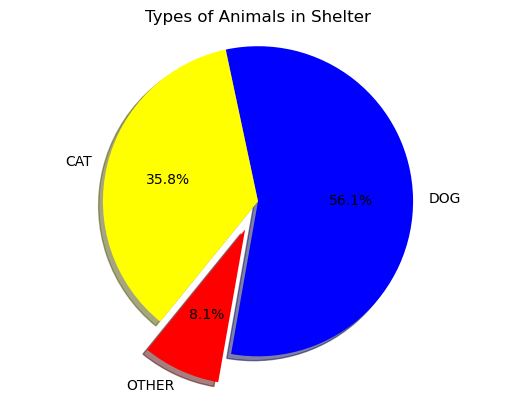

In [113]:
# Isolate to "type" of animal and count occurrence of each value.
type_counts = shelter_df["type"].value_counts()

# Create pie chart
colors=["blue", "yellow", "red"]
explode=(0, 0, 0.2)
plt.pie(type_counts, labels=type_counts.index, explode=explode,
        autopct='%1.1f%%', colors=colors, shadow=True, startangle=260)
plt.title("Types of Animals in Shelter")
plt.axis("equal")
plt.show()


In [114]:
# Specify 'OTHER' category of animal at shelter
other_df = shelter_df.loc[(shelter_df["type"]=="OTHER"),:]

# Count occurrence of each value
other_counts = other_df['breed'].value_counts()
other_counts.head(50)

RABBIT SH           358
CHICKEN             343
BAT                 216
GUINEA PIG          101
GOAT                 90
SHEEP                60
RAT                  49
HORSE                47
PIG                  46
PARAKEET             42
PIGEON               30
KOI                  25
COCKATIEL            23
PEAFOWL              22
LOP-MINI             22
DUCK                 19
GOOSE                18
RACCOON              17
REX                  17
HAMSTER              17
AMERICAN             14
ENGLISH SPOT/MIX     13
LOP-ENGLISH          13
RABBIT LH            13
HOTOT                11
LOP-HOLLAND          11
OPOSSUM               9
DUTCH/MIX             9
CALIFORNIAN           8
MOUSE                 8
FINCH                 8
CANARY                8
PARROT                7
NEW ZEALAND WHT       7
GOAT/LA MANCHA        7
CALIFORNIAN/MIX       7
GOAT/BOER             7
HAVANA/MIX            7
LOP-AMER FUZZY        7
POTBELLY PIG          7
TURTLE                6
DUTCH           

In [116]:
# Need to consolidate'breed' values for fair representation of all species
new_df1 = other_df.loc[other_df['breed'].isin({'RABBIT SH', 'LOP-MINI', 'REX', 'ENGLISH SPOT/MIX',
                                               'LOP-ENGLISH', 'RABBIT LH', 'HOTOT', 'LOP-HOLLAND',
                                               'DUTCH/MIX', 'CALIFORNIAN', 'NEW ZEALAND WHT',
                                               'CALIFORNIAN/MIX', 'HAVANA/MIX', 'LOP-AMER FUZZY',
                                               'DUTCH', 'ENGLISH SPOT', 'HAVANA', 'LOP-FRENCH',
                                               'LOP-ENGLISH/MIX', 'HOTOT/MIX', 'FLEMISH GIANT',
                                               'HARLEQUIN/MIX', 'ANGORA-SATIN/MIX','LOP-HOLLAND/MIX',
                                               'LOP-MINI/MIX', 'NETHERLND DWARF'})] = 'RABBIT'
new_df2 = new_df1.loc[new_df1['breed'].isin({'BOER', 'GOAT/PYGMY', 'GOAT/ALPINE', 'GOAT/LA MANCHA', 'GOAT/BOER'})] = 'GOAT'
new_df3 = new_df2.loc[new_df2['breed'].isin({'PARAKEET', 'COCKATIEL', 'TROPICAL', 'MACAW'})] = 'PARROT'
new_df4 = new_df3.loc[new_df3['breed'].isin({'HAMSTER'})] = 'GUINEA PIG'
new_df5 = new_df4.loc[new_df4['breed'].isin({'POTBELLY PIG'})] = 'PIG'
new_df6 = new_df5.loc[new_df5['breed'].isin({'QUARTER HORSE'})] = 'HORSE'

# Count occurrence of each new value
new_df6['breed'].value_counts()
new_df6.head(50)

AttributeError: 'str' object has no attribute 'loc'